<a href="https://colab.research.google.com/github/Theophine/Time-series-forecasting-/blob/main/Simple_Buy_Sales_Forecasting_(SARIMAX_and_auto_arima_model)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> Business Goals </h3>

<h4> the company for which we are engaging in this forecast for is called Simple_buy and they deal in apparels (winter clothes). Unfortunately, due to poor foreast in the deman for winter clothese, production was low while demand was high. As a result, this led to a huge Loss of clientel. Therefore, the company would like an accurate forecast of future demand for winter clothese so as to optimize production </h4> 

<h3> Problem Statement </h3> 

<h4> The goal of this forecasting project is to use the historical data for the past two years in order to forecast the demand for the next 6 months. this is to ensure that production is optimized   </h4> 

<h3> Import data preprocessing packages </h3> 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

sns.set_style('darkgrid')
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean

<h4> Below, we import the train and validation data </h4> 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Train_KQyJ5eh.csv to Train_KQyJ5eh (3).csv


In [ ]:
import pandas as pd
import io
dataframe_train = pd.read_csv(io.BytesIO(uploaded['Train_KQyJ5eh.csv']),parse_dates = True,index_col= 'Date')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving valid_data.csv to valid_data (3).csv


In [ ]:
import pandas as pd
import io
dataframe_valid = pd.read_csv(io.BytesIO(uploaded['valid_data.csv']),parse_dates = True,index_col= 'Date')

<h3> Below we inspect the data </h3> 

In [ ]:
#check their shapes 
dataframe_train.shape[0], dataframe_valid.shape[0]

(587, 184)

In [ ]:
dataframe_train.head()

,Number_SKU_Sold
Date,
2007-01-01,31762
2007-01-02,285955
2007-01-03,740781
2007-01-04,508796
2007-01-05,445951


<h3> Data preprocessing </h3> 

In [ ]:
#make a copy of your original dataset

df_copy = dataframe_train.copy()

#test code 
df_copy.shape

(587, 1)

In [ ]:
df_copy['Number_SKU_Sold'].describe()

count    5.870000e+02
mean     4.118112e+06
std      1.015100e+07
min      3.176200e+04
25%      1.075948e+06
50%      2.784444e+06
75%      5.208588e+06
max      1.925327e+08
Name: Number_SKU_Sold, dtype: float64

In [ ]:
print('The average sales over the 2 year period is {:.4f}'.format(df_copy['Number_SKU_Sold'].mean()))
print('The maximum sale over the 2 year period is {:.0f}'.format(df_copy['Number_SKU_Sold'].max()))
print('the minimum sale over the 2 year period is {:.0f}'.format(df_copy['Number_SKU_Sold'].min()))

The average sales over the 2 year period is 4118111.5486
The maximum sale over the 2 year period is 192532706
the minimum sale over the 2 year period is 31762


<h4> Quick plot of our dataset </h4> 

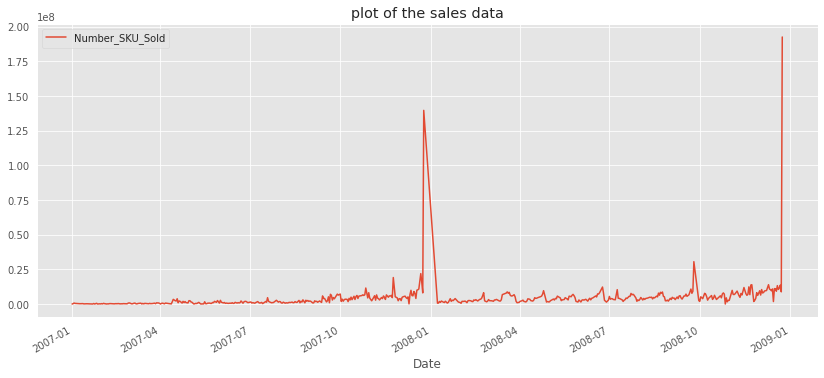

In [ ]:
df_copy.plot(figsize = (14, 6));
plt.title('plot of the sales data');
plt.show();

<H4> check for missing values </h4>

In [ ]:
df_copy.isnull().sum()

Number_SKU_Sold    0
dtype: int64

<H3> Quick observations </h3> 

<h4> The dataset says 2 years but we have only 587 observations in our dataset which means that there are actually missing dataranges. </h4> 

<h4> Also, there is no missing values in our dataset presently, but when we resample, chances are that we might have to interpolate to fill missing values </h4> 

<h4> Furthermore, there are very few outliers which might have to be removed so we can properly inpsect the data for seasonality </h4> 

<H4> before we discard any outlier, we need to firstly check how many values are outliers </h4> 

In [ ]:
print('The value at the 95 percentile is ', str(np.percentile(df_copy['Number_SKU_Sold'], 95)))
print('The value at the 97 percentile is ', str(np.percentile(df_copy['Number_SKU_Sold'], 97)))
print('The value at the 99 percentile is ', str(np.percentile(df_copy['Number_SKU_Sold'], 99)))


The value at the 95 percentile is  9855528.099999992
The value at the 97 percentile is  10975127.499999993
The value at the 99 percentile is  14225472.619999975


<h4> We could plot the outlier to visualize it </h4> 

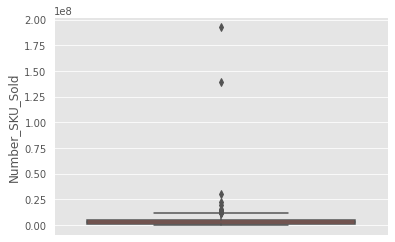

In [ ]:
sns.boxplot(y = df_copy['Number_SKU_Sold']);

<h4> Clearly from the above, we have some values which are above the top whisker and we might have to get rid of them for our time series to work effectively. We start by finding the sales value at the top whisker </h4> 

In [ ]:
percentile_75 = np.percentile(df_copy['Number_SKU_Sold'], 75)
percentile_25 = np.percentile(df_copy['Number_SKU_Sold'], 25)
#percentile_75
IQR =  percentile_75 - percentile_25
#IQR
top_whisker_value = (1.5 * IQR) + percentile_75
top_whisker_value

11407547.25

<h4> select all the values above the top whisker </h4> 

In [ ]:
len(df_copy[df_copy['Number_SKU_Sold'] > top_whisker_value])

16

<h4> replace all outlier values with nan so that we can fill them up with values that are closers to other values </h4> 

In [ ]:
df_copy[df_copy['Number_SKU_Sold'] > top_whisker_value] = np.nan

In [ ]:
#check that the code works 
df_copy.isnull().sum()

Number_SKU_Sold    16
dtype: int64

<h4> we now replace the missing outlier values </h4> 

In [ ]:
df_copy.interpolate(inplace = True)

<H4> replot our newly formed time series </h4> 

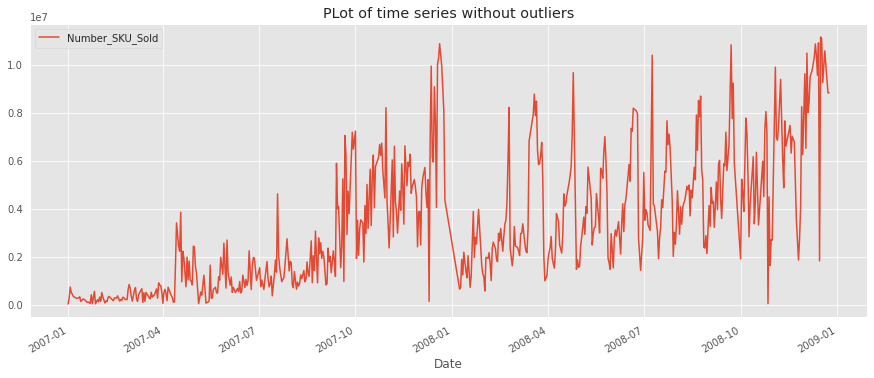

In [ ]:
df_copy.plot(figsize = (15, 6))
plt.title('PLot of time series without outliers')
plt.show();

<h4> Time to fix the missing date ranges </h4> 

In [ ]:
df_copy.index.max(), df_copy.index.min()

(Timestamp('2008-12-24 00:00:00'), Timestamp('2007-01-01 00:00:00'))

In [ ]:
#calculate how many days should be within that date range 
(df_copy.index.max() - df_copy.index.min()).days

723

<h4> Next step is to inspect the missing date ranges and try to unravel why there are missing days and which are missing </h4>

In [ ]:
pd.date_range(start = df_copy.index.min(), end = df_copy.index.max()).difference(df_copy.index)

DatetimeIndex(['2007-01-07', '2007-01-08', '2007-01-10', '2007-01-14',
               '2007-01-17', '2007-01-21', '2007-01-25', '2007-01-28',
               '2007-02-04', '2007-02-10',
               ...
               '2008-11-01', '2008-11-02', '2008-11-07', '2008-11-09',
               '2008-11-14', '2008-11-16', '2008-11-24', '2008-11-30',
               '2008-12-07', '2008-12-09'],
              dtype='datetime64[ns]', length=137, freq=None)

In [ ]:
df_missing = pd.DataFrame(data = pd.date_range(start = df_copy.index.min(), end = df_copy.index.max()).difference(df_copy.index), columns = ['date'])
df_missing.head()

,date
0,2007-01-07
1,2007-01-08
2,2007-01-10
3,2007-01-14
4,2007-01-17


In [ ]:
df_missing.set_index('date', inplace = True)

In [ ]:
df_missing['weekday_name'] = df_missing.index.weekday
df_missing['month'] = df_missing.index.month
df_missing['year'] = df_missing.index.year

In [ ]:
df_missing.head()

,weekday_name,month,year
date,,,
2007-01-07,6,1,2007
2007-01-08,0,1,2007
2007-01-10,2,1,2007
2007-01-14,6,1,2007
2007-01-17,2,1,2007


##observation
weekday '6' represents sunday

weekday '0' represents monday 

weekday '1' represents Tuesday 

weekday '2' represents wednesday 

weekday '3' represents Thursday 

weekday '4' represents Friday 

weekday '5' represents saturday 

<h4> Inspect exactly new variables and see wher there are more missing values </h4> 

In [ ]:
df_missing['weekday_name'].value_counts()

6    86
5    14
4    10
0    10
3     6
2     6
1     5
Name: weekday_name, dtype: int64

<h4> check out what month has the most missing values </h4> 

In [ ]:
df_missing['month'].value_counts()

1     19
9     13
7     13
6     13
11    12
3     12
12    10
10    10
5     10
4      9
2      9
8      7
Name: month, dtype: int64

<h4> Use a crosstab function to better understand range of  missing values </h4> 

In [ ]:
pd.crosstab(df_missing['weekday_name'], df_missing['year']).transpose()

weekday_name,0,1,2,3,4,5,6
year,,,,,,,
2007,4,1,5,5,3,6,43
2008,6,4,1,1,7,8,43


<h3> what can we infer from the inspection </h3> 

<H4> Sales is done 6 days a week and sunday is officially closed. Therefore, we will remove the sundays</h4> 

<h4> there are missing values in other days which could be due to error in capturing the data, or jsut holidays </h4> 



<h3> We will set out frequency to week day frequency and then remove the sundays. this will revert to the full length of 723 </h3> 

In [ ]:
df_full = df_copy.asfreq('d')

In [ ]:
#check how many missing values 
df_full.isna().sum()

Number_SKU_Sold    137
dtype: int64

In [ ]:
df_full['weekday'] = df_full.index.weekday

In [ ]:
df_full.head(10)

,Number_SKU_Sold,weekday
Date,,
2007-01-01,31762.0,0
2007-01-02,285955.0,1
2007-01-03,740781.0,2
2007-01-04,508796.0,3
2007-01-05,445951.0,4
2007-01-06,347351.0,5
2007-01-07,NaN,6
2007-01-08,NaN,0
2007-01-09,269415.0,1


<h4> Select the dataframe that do not contain sunday </h4> 

In [ ]:
df_new = df_full[df_full['weekday'] != 0]
df_new.head(8)

,Number_SKU_Sold,weekday
Date,,
2007-01-02,285955.0,1
2007-01-03,740781.0,2
2007-01-04,508796.0,3
2007-01-05,445951.0,4
2007-01-06,347351.0,5
2007-01-07,NaN,6
2007-01-09,269415.0,1
2007-01-10,NaN,2


<h4> Check how many missing values exist in the dataset </h4> 

In [ ]:
df_new.isna().sum()

Number_SKU_Sold    127
weekday              0
dtype: int64

In [ ]:
#below we fix the missig values
df_new.interpolate(inplace = True)

In [ ]:
#test the code 
df_new.isna().sum()

Number_SKU_Sold    0
weekday            0
dtype: int64

In [ ]:
#check the frequency of the dataset
df_new.index

DatetimeIndex(['2007-01-02', '2007-01-03', '2007-01-04', '2007-01-05',
               '2007-01-06', '2007-01-07', '2007-01-09', '2007-01-10',
               '2007-01-11', '2007-01-12',
               ...
               '2008-12-13', '2008-12-14', '2008-12-16', '2008-12-17',
               '2008-12-18', '2008-12-19', '2008-12-20', '2008-12-21',
               '2008-12-23', '2008-12-24'],
              dtype='datetime64[ns]', name='Date', length=620, freq=None)

<h3> Feature Extraction and data Exploration </h3> 

<h4> Below is a rolling mean plot where we attempt to view long term trend of our data </h4> 

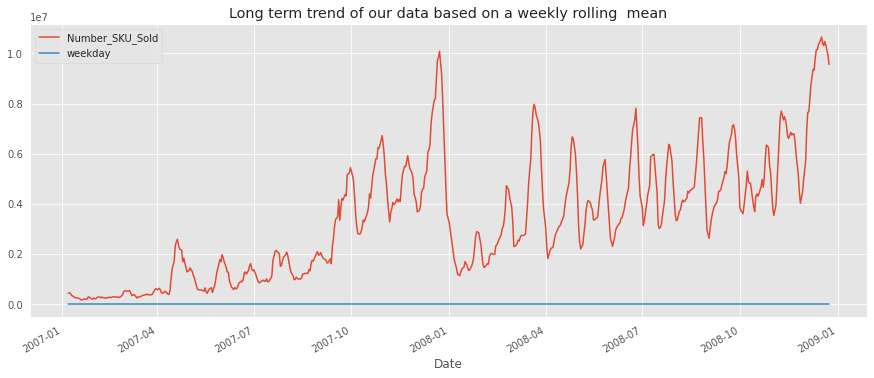

In [ ]:
df_new.rolling(window = 6, min_periods = 6).mean().plot(figsize = (15, 6))
plt.title('Long term trend of our data based on a weekly rolling  mean')
plt.show();                                                    

<h4> view seasonal trend </h4> 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df_seasonal = seasonal_decompose(df_new['Number_SKU_Sold'], model = 'multiplicative', freq = 6)

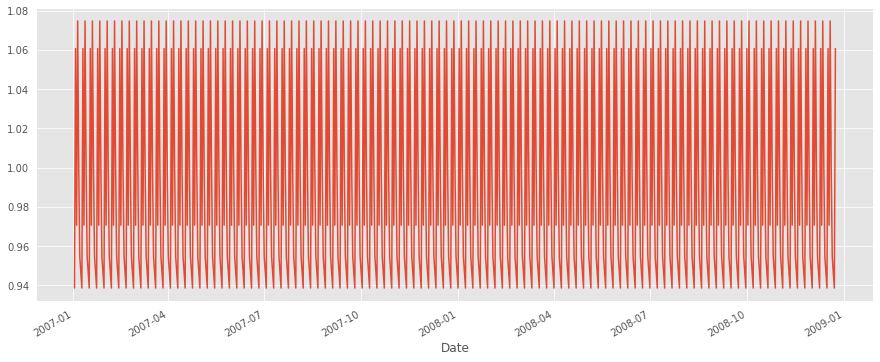

In [ ]:
df_seasonal.seasonal.plot(figsize = (15, 6))
plt.show();

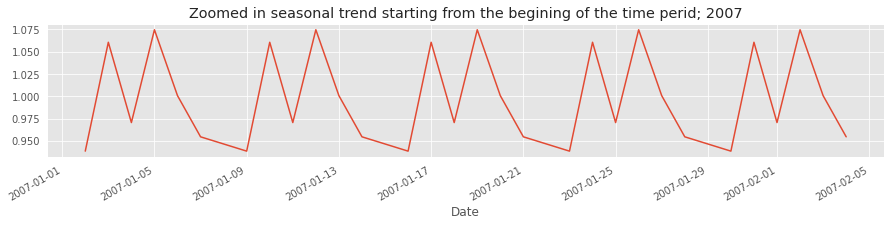

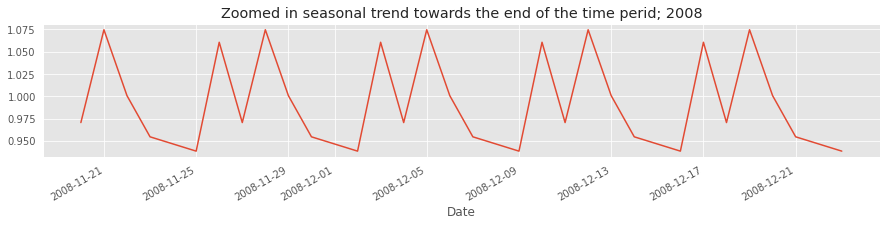

In [ ]:
#we can zoom in to better understand the seasonal pattern
plt.subplot(2, 1, 1)
df_seasonal.seasonal[0: 30].plot(figsize = (15, 6));
plt.title('Zoomed in seasonal trend starting from the begining of the time perid; 2007')
plt.show();

plt.subplot(2, 1, 2)
df_seasonal.seasonal[590: -1].plot(figsize = (15, 6));
plt.title('Zoomed in seasonal trend towards the end of the time perid; 2008')
plt.show();

<h4> from the above, it is clear that the seasonal pattern persists. it has a cycle of 7 days </h4> 

<h4> Data exploration stage. we need to break our data into individual date components for easier exploration</h4> 

In [ ]:
df_new['year'] = df_new.index.year
df_new['month'] = df_new.index.month
df_new['weekday'] = df_new.index.weekday
df_new['dayofyear'] = df_new.index.dayofyear
df_new['week'] = df_new.index.week
df_new['quarter'] = df_new.index.quarter

df_new.head(7)

,Number_SKU_Sold,weekday,year,month,dayofyear,week,quarter
Date,,,,,,,
2007-01-02,285955.0,1,2007,1,2,1,1
2007-01-03,740781.0,2,2007,1,3,1,1
2007-01-04,508796.0,3,2007,1,4,1,1
2007-01-05,445951.0,4,2007,1,5,1,1
2007-01-06,347351.0,5,2007,1,6,1,1
2007-01-07,308383.0,6,2007,1,7,1,1
2007-01-09,269415.0,1,2007,1,9,2,1


In [ ]:
df_new.shape

(620, 7)

<h4> We plot the distribution of yearly sales </h4> 

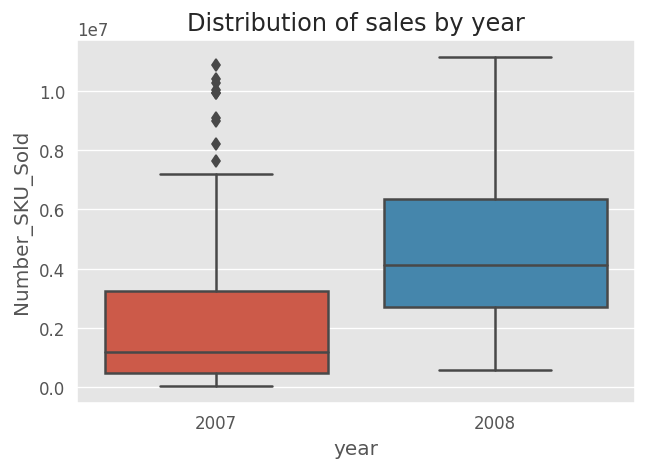

In [ ]:
plt.figure(dpi = 120)
sns.boxplot(y = 'Number_SKU_Sold', x = 'year', data = df_new)
plt.title('Distribution of sales by year');
plt.show();

<h4> Based on the distribution of sales by, it shows that there is an increase in sales from 2007 to 2008 </h4> 

<h4>distribution of sales by days of the week </h4> 

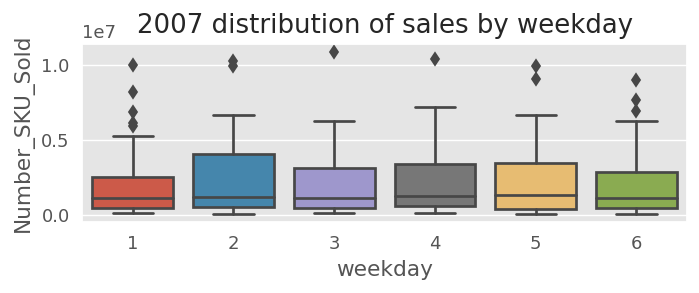

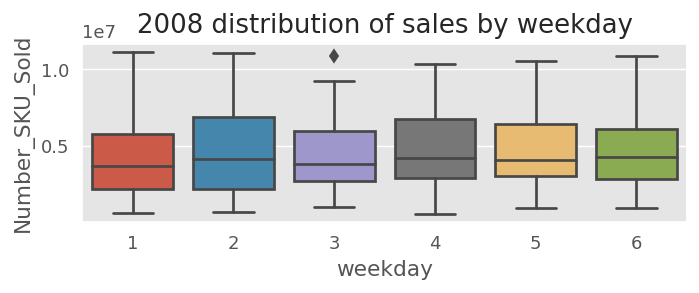

In [ ]:

df_2007 = df_new[df_new['year'] == 2007]
df_2008 = df_new[df_new['year'] == 2008]

plt.figure(dpi = 130)

plt.subplot(2, 1, 1)
plt.title('2007 distribution of sales by weekday')
sns.boxplot(x = 'weekday', y = 'Number_SKU_Sold', data = df_2007)
plt.show();

plt.figure(dpi = 130)
plt.subplot(2, 1, 1)
plt.title('2008 distribution of sales by weekday')
sns.boxplot(x = 'weekday', y = 'Number_SKU_Sold', data = df_2008)

plt.show();

<h4> distribution of sales by months of the year </h4> 

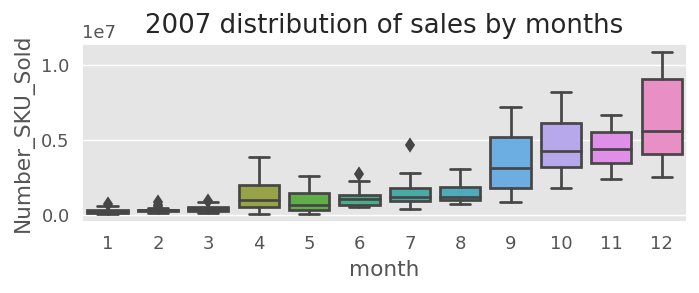

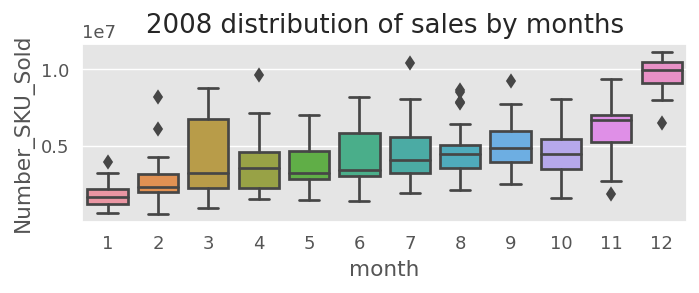

In [ ]:
df_2007 = df_new[df_new['year'] == 2007]
df_2008 = df_new[df_new['year'] == 2008]

plt.figure(dpi = 130)

plt.subplot(2, 1, 1)
plt.title('2007 distribution of sales by months')
sns.boxplot(x = 'month', y = 'Number_SKU_Sold', data = df_2007)
plt.show();

plt.figure(dpi = 130)
plt.subplot(2, 1, 1)
plt.title('2008 distribution of sales by months')
sns.boxplot(x = 'month', y = 'Number_SKU_Sold', data = df_2008)

plt.show();

<h3> Conclusion from the exploration </h3> 

<h4> There are clear differences between the distribution of sales by month and weekday for each year. while the distriubiton of sales for 2007 weekdays remained faily constant, the distribution of sales for 2008 weekdays shows a random trend with decline towards the end of the week </h4> 

<h4> From the monthly distribution, it shows that for 2007, there was a steady increase over the month with high extremely high sales towards the yuletide period. However, 2008 was quite different compared to 2007, there was no stable trend. the sales did not increase steadily over the month like in 2007 but showed upwards and downwards movement with November and december recording the highest sales </h4> 

<h3> Model building stage </h3> 

<h3> split your data into train and validation set </h3> 

In [ ]:
train_data = df_new[:550]
validation_data = df_new[550:]

len(train_data), len(validation_data)

(550, 70)

<h4> Plot your train and validation set </h4> 

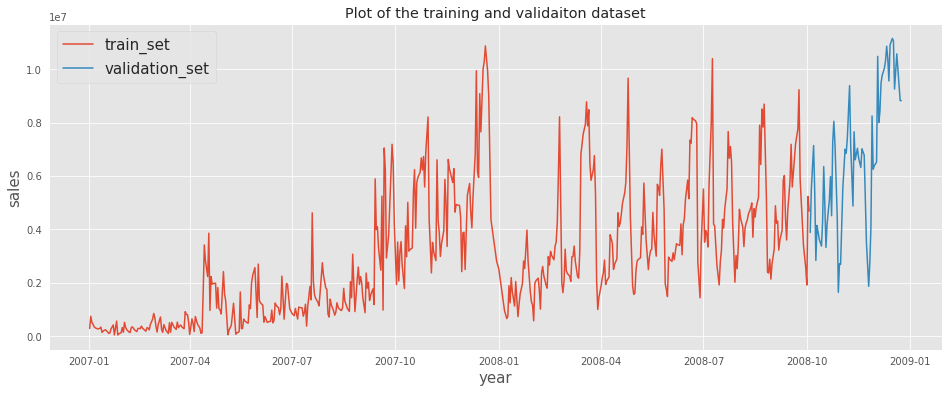

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(train_data['Number_SKU_Sold'], label = 'train_set')
plt.plot(validation_data['Number_SKU_Sold'], label = 'validation_set')
plt.legend(fontsize = 15);
plt.title('Plot of the training and validaiton dataset')
plt.xlabel('year', fontsize = 15);
plt.ylabel('sales', fontsize = 15);
plt.show();

<h4> Test for stationarity </h4> 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(train_data['Number_SKU_Sold'])

(-2.2012580237706763,
 0.20578918367841226,
 19,
 530,
 {'1%': -3.4427485933555886,
  '10%': -2.569682641509434,
  '5%': -2.8670087381529723},
 16304.379681937266)

<H4> From the above, the time series in definitely not stationary </h4>

<H4> Given the presence of seasonality and the fact that the trend is mulitpliative, we would transform using Log_transform and then do seasonal adjustment. Then we would perform non-seasonal stationarity </h4> 

In [ ]:
#perform log transformation
train_data['Number_SKU_Sold_log'] = np.log(train_data['Number_SKU_Sold'])
train_data.head()

,Number_SKU_Sold,weekday,year,month,dayofyear,week,quarter,Number_SKU_Sold_log
Date,,,,,,,,
2007-01-02,285955.0,1,2007,1,2,1,1,12.563590
2007-01-03,740781.0,2,2007,1,3,1,1,13.515460
2007-01-04,508796.0,3,2007,1,4,1,1,13.139802
2007-01-05,445951.0,4,2007,1,5,1,1,13.007964
2007-01-06,347351.0,5,2007,1,6,1,1,12.758091


In [ ]:
#Perform seasonal adjustment 
train_data['Number_SKU_Sold_log_7'] = train_data['Number_SKU_Sold_log'].diff(periods = 7)

#check code 
train_data.head(8)

,Number_SKU_Sold,weekday,year,month,dayofyear,week,quarter,Number_SKU_Sold_log,Number_SKU_Sold_log_7
Date,,,,,,,,,
2007-01-02,285955.0,1,2007,1,2,1,1,12.563590,NaN
2007-01-03,740781.0,2,2007,1,3,1,1,13.515460,NaN
2007-01-04,508796.0,3,2007,1,4,1,1,13.139802,NaN
2007-01-05,445951.0,4,2007,1,5,1,1,13.007964,NaN
2007-01-06,347351.0,5,2007,1,6,1,1,12.758091,NaN
2007-01-07,308383.0,6,2007,1,7,1,1,12.639098,NaN
2007-01-09,269415.0,1,2007,1,9,2,1,12.504008,NaN
2007-01-10,278009.0,2,2007,1,10,2,1,12.535409,-0.028181


<H4> visualize the new series and also check if it is now stationary <h4> 

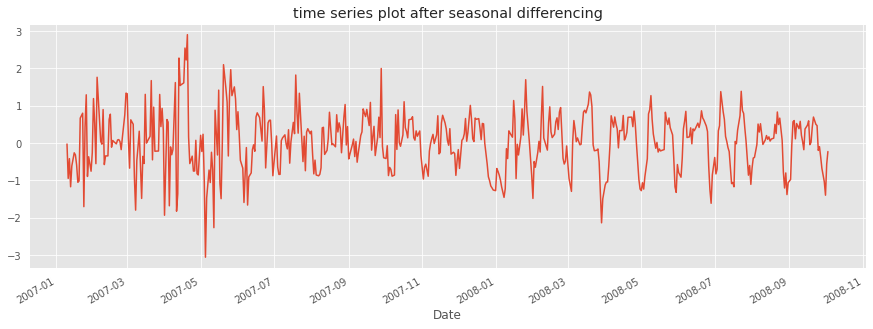

In [ ]:
train_data['Number_SKU_Sold_log_7'].plot(figsize = (15, 5));
plt.title('time series plot after seasonal differencing')
plt.show();

In [ ]:
#we check for stationarity again 
adfuller(train_data['Number_SKU_Sold_log_7'].dropna())

(-8.586962780879043,
 7.462193218799609e-14,
 18,
 524,
 {'1%': -3.4428912664970523,
  '10%': -2.5697161081813413,
  '5%': -2.867071538125014},
 824.204038421169)

<h4> From the above, there still seem to be a pattern but the data is now stationary. But given the existence of the pattern we therefore, we conduct non-seasonal differencing </h4> 

<h3> Non-seasonal differencing </h3> 

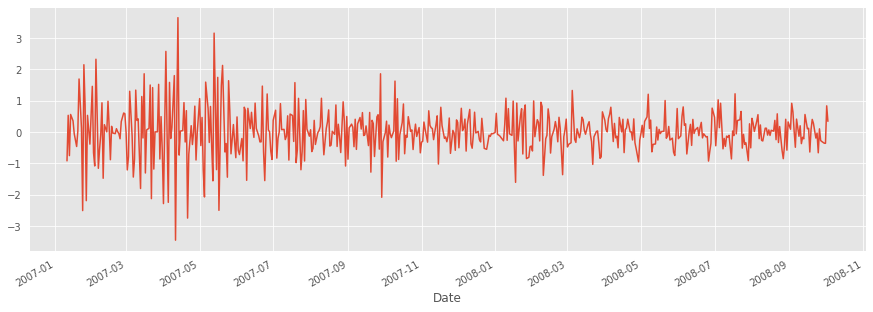

In [ ]:
train_data['Number_SKU_Sold_log_7_1'] = train_data['Number_SKU_Sold_log_7'].diff(1)
train_data['Number_SKU_Sold_log_7_1'].plot(figsize = (15, 5));

<h3> recompute the stationarity </h3> 

In [ ]:
adfuller(train_data['Number_SKU_Sold_log_7_1'].dropna())

(-9.42508629998037,
 5.373474702350744e-16,
 18,
 523,
 {'1%': -3.4429153652063986,
  '10%': -2.5697217608736187,
  '5%': -2.8670821452874007},
 882.7422205694833)

<h4> From the adfuller test, it shows that 18 lags into the past will give us a good prediction today </h4> 

<H4> time to find the values of P and Q, for both the seasonal and non-seasonal data </h4> 

<h4> below are the pacf and acf for the seasonal components </h4> 

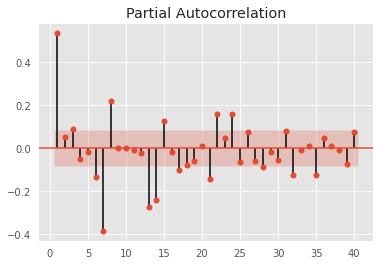

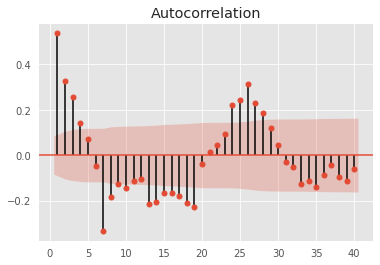

In [ ]:
plot_pacf(train_data['Number_SKU_Sold_log_7'].dropna(), lags = 40, method = 'ols', zero = False)

plot_acf(train_data['Number_SKU_Sold_log_7'].dropna(), lags = 40, zero = False)
plt.show();



<h4> Below are the pacf and the acf for the non-seasonal components </h4>

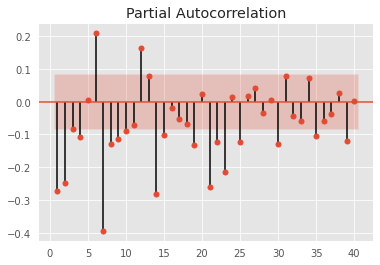

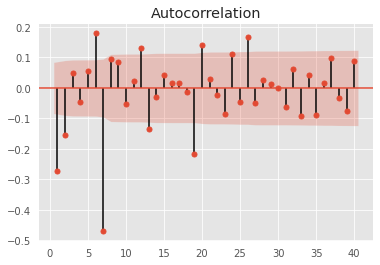

In [ ]:
plot_pacf(train_data['Number_SKU_Sold_log_7_1'].dropna(), lags = 40, method = 'ols', zero = False)

plot_acf(train_data['Number_SKU_Sold_log_7_1'].dropna(), lags = 40, zero = False)
plt.show();


<h3> what is the autocorrelation of the series </h4> 

In [ ]:
train_data['Number_SKU_Sold_log_7_1'].autocorr()

-0.27317462295474365

<h3> Train the model </h3> 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
sarima_model = SARIMAX(train_data['Number_SKU_Sold'], order = (2,1,1), seasonal_order= (4,0,2,7), trend = 't')
sarima_result = sarima_model.fit()
sarima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                        Number_SKU_Sold   No. Observations:                  550
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2], 7)   Log Likelihood               -8425.257
Date:                                Tue, 13 Apr 2021   AIC                          16872.514
Time:                                        21:13:20   BIC                          16919.903
Sample:                                             0   HQIC                         16891.035
                                                - 550                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         19.5879     15.827      1.238      0.216     -11.433      50.609
ar.L1          0.7447      0.037     20.279      0.000       0.673       0.817
ar.L2          0.0158      0.042      0.375      0.708      -0.067       0.098
ma.L1         -0.9786      0.011    -90.529      0.000      -1.000      -0.957
ar.S.L7       -1.5723      0.127    -12.390      0.000      -1.821      -1.324
ar.S.L14      -0.5955      0.124     -4.794      0.000      -0.839      -0.352
ar.S.L21       0.0584      0.099      0.591      0.555      -0.135       0.252
ar.S.L28      -0.0538      0.064     -0.843      0.399      -0.179       0.071
ma.S.L7        1.7256      0.114     15.099      0.000       1.502       1.950
ma.S.L14       0.8661      0.099      8.741      0.000       0.672       1.060
sigma2      1.398e+12   3.28e-10   4.26e+21      0.000     1.4e+12     1.4e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               297.20
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.74   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.69e+37. Standard errors may be unstable.
"""

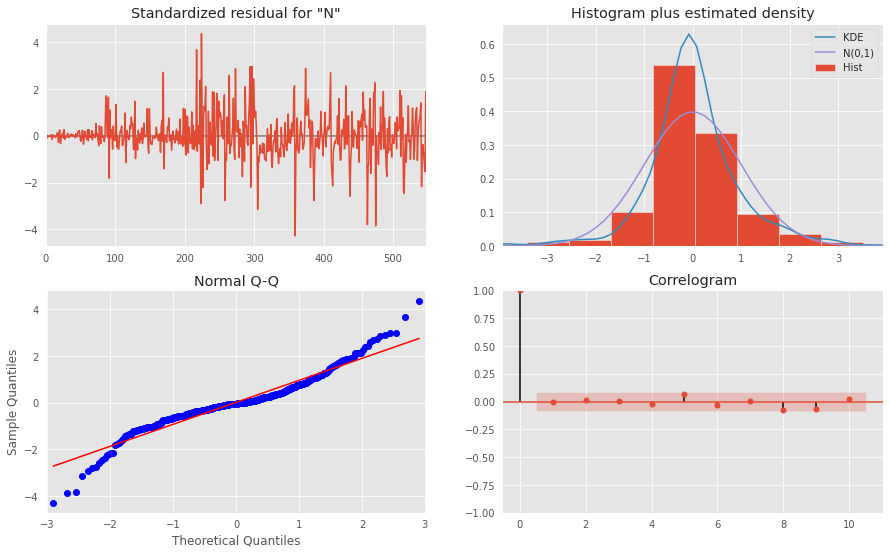

In [ ]:
sarima_result.plot_diagnostics(figsize = (15, 9))
plt.show();

<h3> check if the residuals are correlated </h3> 

In [ ]:
adfuller(sarima_result.resid)

(-23.37825237598584,
 0.0,
 0,
 549,
 {'1%': -3.4423174665535385,
  '10%': -2.569581505602171,
  '5%': -2.866818952732754},
 16283.119568011065)

In [ ]:
len(train_data) + len(validation_data)

620

In [ ]:
sarima_pred = sarima_result.get_prediction(start = 0, end = 621)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
sarima_pred_mean = sarima_pred.predicted_mean[552:]
sarima_pred_mean.index = validation_data.index

In [ ]:
len(validation_data), len(sarima_pred_mean)

(70, 70)

In [ ]:
lower_conf = sarima_pred.conf_int()[552:]['lower Number_SKU_Sold']
upper_conf  = sarima_pred.conf_int()[552:]['upper Number_SKU_Sold']

lower_conf.index = sarima_pred_mean.index
upper_conf.index = sarima_pred_mean.index

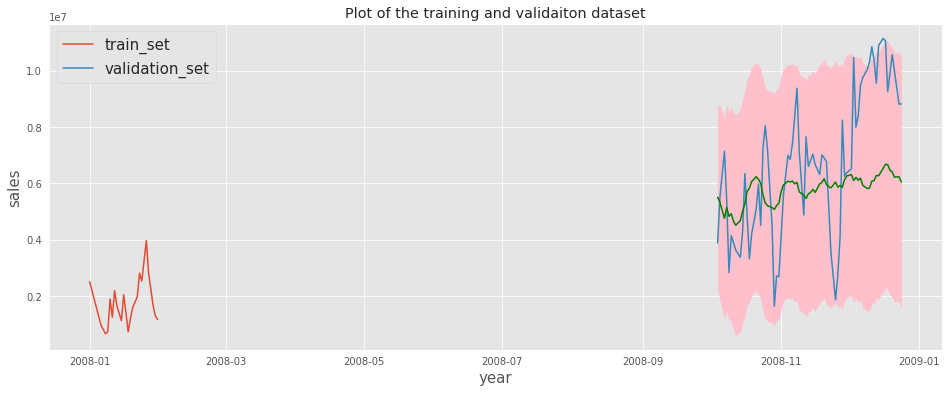

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(train_data['Number_SKU_Sold']['2008-1'], label = 'train_set')
plt.plot(validation_data['Number_SKU_Sold'], label = 'validation_set')
plt.plot(sarima_pred_mean, color = 'green')
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color = 'pink');
plt.legend(fontsize = 15);
plt.title('Plot of the training and validaiton dataset')
plt.xlabel('year', fontsize = 15);
plt.ylabel('sales', fontsize = 15);
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [ ]:
np.sqrt(mean_squared_error(validation_data['Number_SKU_Sold'], sarima_pred_mean))

2451969.2684300584

In [ ]:
np.sqrt(mean_squared_log_error(validation_data['Number_SKU_Sold'], sarima_pred_mean))

0.4057114695583604

<h3> Train with auto-arima </h3>

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
auto_arima_model = auto_arima(train_data['Number_SKU_Sold'], start_p = 1, start_q =1, max_d = 2, start_P = 1, max_D = 2, 
          start_Q= 1,  max_P = 5, max_Q = 3, max_p = 6, max_q =  4, m= 7,  seasonal= True, n_jobs= -1, trend = 't', trace = True, random_state = 42, 
                             error_action='ignore', stepwise = False)


auto_arima_model.summary()


Best model:  ARIMA(1,1,1)(1,0,2)[7] intercept
Total fit time: 71.117 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -8428.927
Date:                                Tue, 13 Apr 2021   AIC                          16871.853
Time:                                        21:17:06   BIC                          16902.010
Sample:                                             0   HQIC                         16883.639
                                                - 550                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          9.3487      7.767      1.204      0.229      -5.875      24.572
ar.L1          0.7673      0.028     27.349      0.000       0.712       0.822
ma.L1         -0.9820      0.009   -107.115      0.000      -1.000      -0.964
ar.S.L7       -0.7613      0.179     -4.246      0.000      -1.113      -0.410
ma.S.L7        0.9165      0.182      5.036      0.000       0.560       1.273
ma.S.L14       0.1927      0.043      4.526      0.000       0.109       0.276
sigma2      1.402e+12   9.15e-11   1.53e+22      0.000     1.4e+12     1.4e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               313.10
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               4.75   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.57e+37. Standard errors may be unstable.
"""

<h4> Below is the model diagnostics for the auto_arima model </h4> 

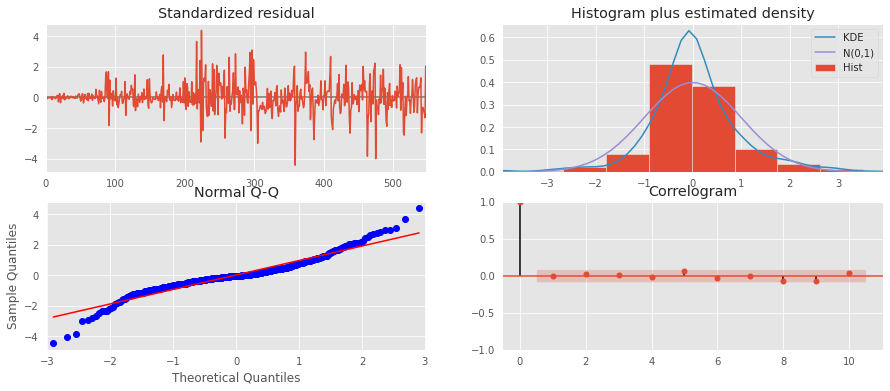

In [ ]:
auto_arima_model.plot_diagnostics(figsize = (15, 6))
plt.show();

In [ ]:
auto_arima_pred = auto_arima_model.predict(n_periods= 70, return_conf_int= True)

In [ ]:
df_auto_arima_pred = pd.DataFrame(data = auto_arima_pred[0], index = validation_data.index, columns = ['prediction'])
df_auto_arima_pred.head()

,prediction
Date,
2008-10-04,4.439357e+06
2008-10-05,4.696545e+06
2008-10-07,4.896931e+06
2008-10-08,5.011019e+06
2008-10-09,4.793886e+06


<h4> below are the lower and upper confidence interval of the arima models </h4> 

In [ ]:
auto_arima_pred_lower_conf = auto_arima_pred[1][:, 0]
auto_arima_pred_upper_conf = auto_arima_pred[1][:, 1]

<h4> Plot the prediction got by using the auto-arima </h4> 

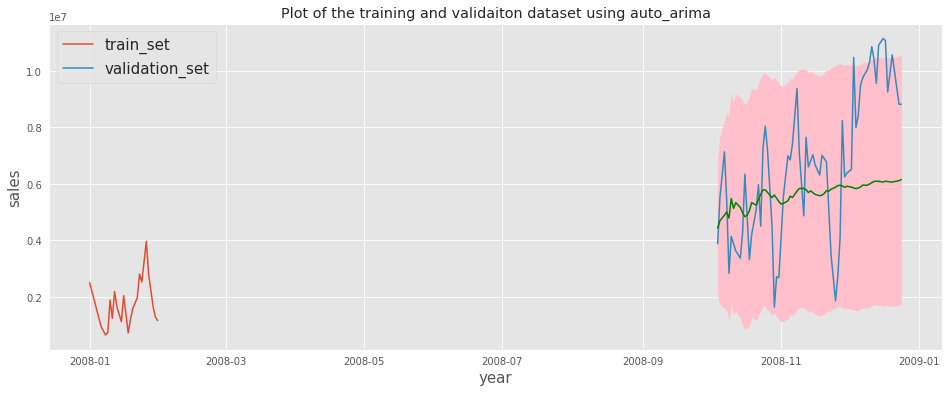

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(train_data['Number_SKU_Sold']['2008-1'], label = 'train_set')
plt.plot(validation_data['Number_SKU_Sold'], label = 'validation_set')
plt.plot(df_auto_arima_pred, color = 'green')
plt.fill_between(validation_data.index, auto_arima_pred[1][:, 0], auto_arima_pred[1][:, 1], color = 'pink');
plt.legend(fontsize = 15);
plt.title('Plot of the training and validaiton dataset using auto_arima')
plt.xlabel('year', fontsize = 15);
plt.ylabel('sales', fontsize = 15);
plt.show();

<h2> Conclusion </h2> 

<h3> Given that the data being modelled is not only affected by seasonality but also  by holidays and weekend effects, auto-arima by default performs poorly on these kinds of dataset. Therefore, it is recommended to try the likes of 
Facebook Prohet as it incorporates all these effects as best as possible </h3> 

<h3> Futhermore, the SARIMAX model does a near good job as it tried to mimick the pattern of the validation data </h3> 